# Decision Trees
This is a versatile ML algorithms that can perform both classification and regression tasks, and even multioutput tasks.
## 1. Training and Visualization

In [1]:
import numpy as np
import matplotlib as mpl
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
IMAGE_PATH = Path() / 'images' / 'c6_decision_tree'
IMAGE_PATH.mkdir(parents=True, exist_ok=True)
def save_fig(fig_id, tigh_layout=True, fig_extension='png', resolution=300):
    #IMAGE_PATH.mkdir(parents=True, exist_ok=True)
    path = IMAGE_PATH / f'{fig_id}.{fig_extension}'
    if tigh_layout:
        plt.tigh_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X = iris.data[['petal length (cm)', 'petal width (cm)']].values
y = iris.target

In [4]:
## tree classifier model
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [5]:
X.shape

(150, 2)

In [6]:
tree_clf.classes_

array([0, 1, 2])

In [7]:
tree_clf.tree_

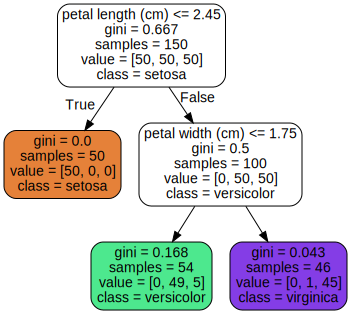

In [8]:
# visualize tree classifying paths 
from sklearn.tree import export_graphviz
from graphviz import Source

export_graphviz(tree_clf,
                out_file=str(IMAGE_PATH / 'iris_tree.dot'),
                feature_names=['petal length (cm)', 'petal width (cm)'],
                class_names=iris.target_names,
                rounded=True,
                filled=True)

Source.from_file(IMAGE_PATH / 'iris_tree.dot')

### 1.1 Makes predictions
We start at *root node* (depth 0), model asks if the petal length is smaller than 2.45? 
- (depth 1) If true, the model makes classified the flower's class as setosa, and model stops prediction. If false, the model goes on the left node and asking again if the petal width is smaller than 1.75? 
- (depth 2) If true, the left node is classified as the versicolor class with 54 instances, but the node's class is not purity. If the petal width is greater than 1.75, the instances are likely the verginica class.

Node's properties:
- A node's `samples` attribute counts the number of instances that are meet the condition before.
- The `value` attribute shows how many training instance of each class in this node applies to, for example, the last node: 0 setosa, 1 versicolor, 45 virginica.
- The `gini` attribute measures its *Gini impurity* (G): G=0 is pure, the last node has impurity equal to 1 - (0/46)^2 - (1/46)^2 - (45/46)^2 = 0.043

*Gini impurity:* $$\displaystyle{\mathcal{G}_i = 1 - \sum^n_{k=1}p_{i,k}^2}$$
- $p_{i,k}$ is the ratio of class k instances among the training instances in the i node.

### 1.2. Estimating Class Probabilities
Tree has method to estimate the probabilities for each *class k* that instance belong to.  

In [9]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [10]:
tree_clf.predict([[5, 1.5]])

array([1])

### 1.3. CART Training Algorithm
The *Classification And Regression Tree* (CART) algorithm to train the decision tree. It splits instances into a binary tree (two subsets) by using a single feature *k* and a threshold *$t_k$ (eg. petal length < 2.45). How does it choose *k* and *$t_k$? It searchs for the pair ($k,t_k$) that produces the **purest** subsets, weight by their size. The cost function that the algorithm tries to minimize:
$$\displaystyle{\mathcal{J}(k,t_k) = \frac{m_{left}}{m}G_{left} + \frac{m_{right}}{m}G_{right} \text{ where }\begin{cases}
G_{left/right} \text{ measures the impurity of the left/right subset} \\
m_{left/right} \text{ is the number of instances in the left/right subset.}
\end{cases}
}$$

The algorithm will stop when reach the maximum depth (`max_depth` hyperparameter). Some hyperparameters control additional stopping conditions: `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, and `max_leaf_nodes`.
### 1.4. Gini Impurity or Entropy?
Default, the class uses the Gini impurity measurement, but we can set the hyperparameter `criterion='entropy'`. Entropy measures of molecular (phan tu) disorder, it approaches zero when molecules are still and well ordered. If a set's entropy is zero when it has only one class.

**Entropy**
$$\displaystyle{H_i = -\sum^n_{k=1}p_{i,k}log_2(p_{i,k})}$$

So, Gini impurity or Entropy? they have no difference on the tree classification. Gini is slightly faster to compute. However, when they differ, Gini impurity tends to isolate the most frequent class in its own brand of the tree, while entropy tends to produce slightly more balanced trees.

## 2. Regularization Hyperparameters
DecisionTree makes a few assumptions about the training data (eg. linear models assume that data is linear). The tree structure will adapt itself to the training data, fitting it very closely - so, most likely overfitting it. Such a model is often called *Nonparametric model* (because some parameters don't need to modify in prior training). In contrast, a *parametric model* (such as linear model) has a predetermined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting (but increasing the risk of underfitting).

To avoid overfitting the training data, we need to restrict the DecisionTree's freedom during training. Which is called regularization. DecisionTree has a few hyperparameters that restrict the shape of the decision tree:
- `max_depth`: reducing the depth of tree, thus reduce the risk of overfitting.
- `max_features`: maximum number of features that are evaluated for splitting at each node.
- `max_leaf_nodes`: maximum number of leaf nodes
- `min_samples_split`: minimum number of samples a node must have before it can be split
- `min_samples_leaf`: minimum number of samples a leaf node must have to be created.
- `min_weight_fraction_leaf`: same as min_samples_leaf but expressed as a fraction of the total number of weighted instances
- Increasing `min_*` or reducing `max_*` hyperparameter will regularize the model.

**Note**: Other algorithms work by first training the DecisionTree without restrictions, then *pruning* (deleting) unnecessary nodes (a node whose children are all leaf nodes). Standard statistical tests (ie. $X^2 (Chi-squared) test) are used to estimate the probability (called *p-value*, is higher than a given threshold (>5%, controlled by hyperparameter), then the node is considered as unnecessary and its children are deleted.

In [11]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=150, noise=0.2, random_state=42)
tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X, y)
tree_clf2.fit(X, y)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

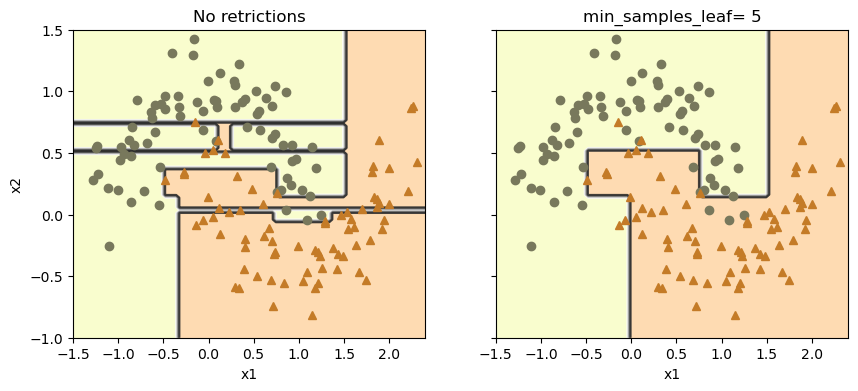

In [12]:
def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100), 
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap='Greys', alpha=0.8)
    colors = {'Wistia': ['#78785c', '#c47b27'], 'Pestel1': ['red', 'blue']}
    markers = ('o', '^')
    for idx in (0, 1):
        plt.plot(X[:, 0][y==idx], X[:, 1][y==idx], 
                 color=colors[cmap][idx], marker=markers[idx], linestyle='none')
    plt.axis(axes)
    plt.xlabel('x1')
    plt.ylabel('x2')
    

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X, y, axes=[-1.5, 2.4, -1, 1.5], cmap='Wistia')
plt.title('No retrictions')

plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X, y, axes=[-1.5, 2.4, -1, 1.5], cmap='Wistia')
plt.title(f'min_samples_leaf= {tree_clf2.min_samples_leaf}')
plt.ylabel('')
plt.show()

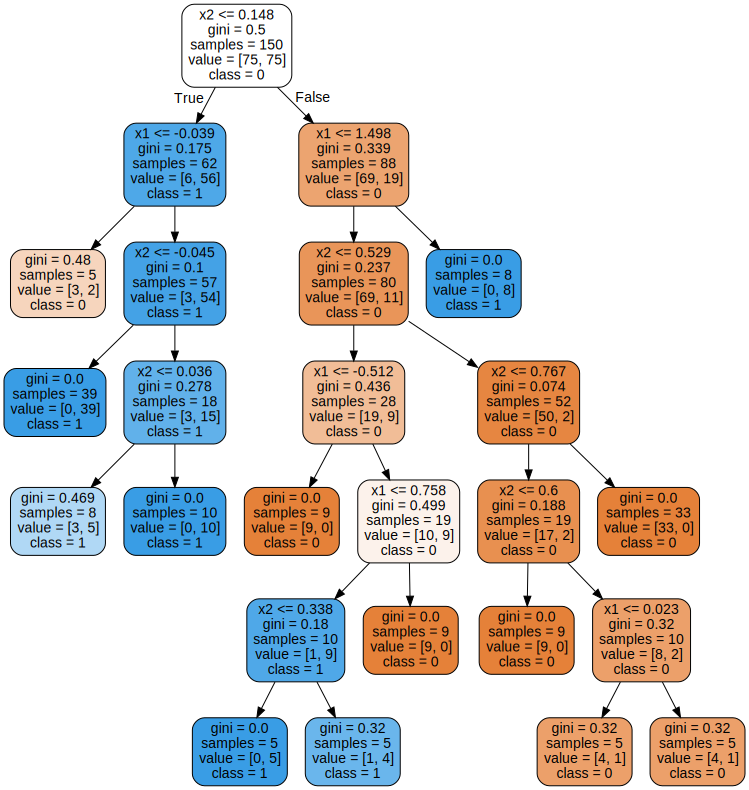

In [13]:
export_graphviz(tree_clf2,
                out_file=str(IMAGE_PATH / 'make_moons_regularized.dot'),
                feature_names=['x1', 'x2'],
                class_names=np.array(['0', '1']),
                rounded=True,
                filled=True)

Source.from_file(IMAGE_PATH / 'make_moons_regularized.dot')

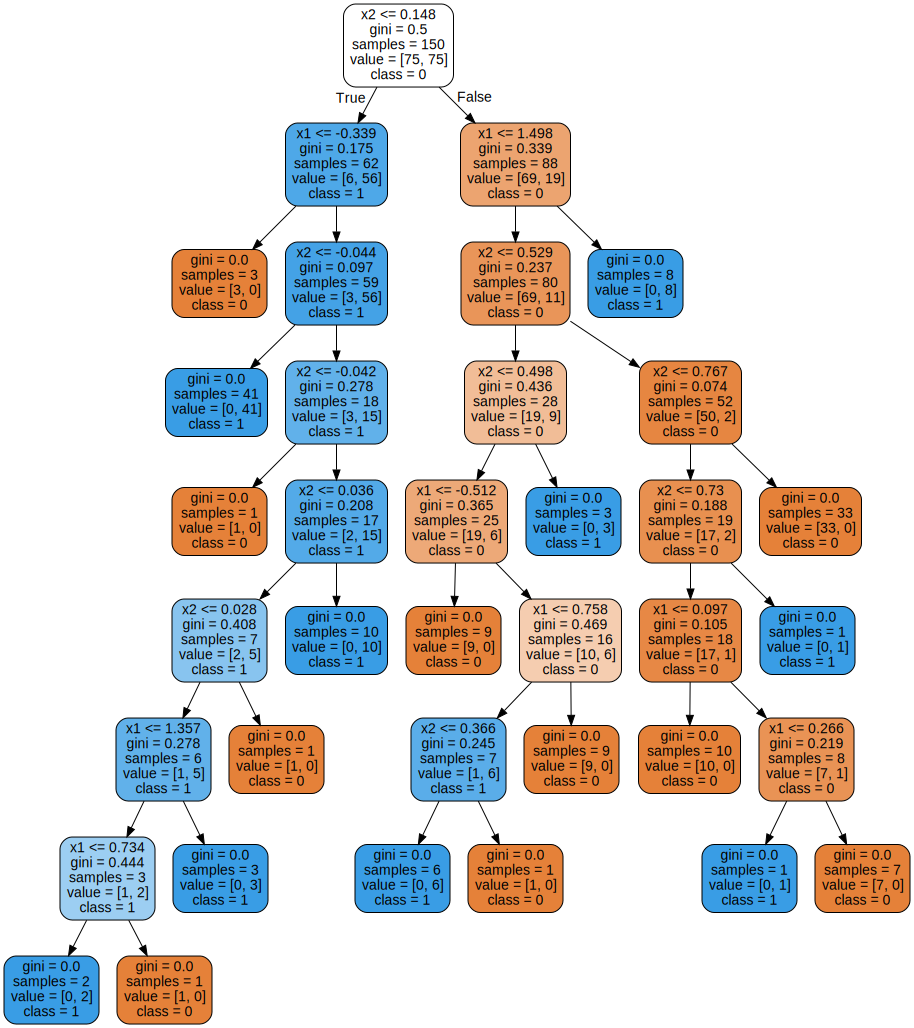

In [14]:
export_graphviz(tree_clf1,
                out_file=str(IMAGE_PATH / 'make_moons.dot'),
                feature_names=['x1', 'x2'],
                class_names=np.array(['0', '1']),
                rounded=True,
                filled=True)

Source.from_file(IMAGE_PATH / 'make_moons.dot')

In [15]:
Xtest, ytest = make_moons(n_samples=100, noise=0.2, random_state=43)

tree_clf1.score(Xtest, ytest)

0.89

In [16]:
tree_clf2.score(Xtest, ytest)

0.92

In [17]:
tree_clf1.get_depth()

8

In [18]:
tree_clf2.get_depth()

6

In [19]:
tree_clf2.feature_importances_

array([0.37453926, 0.62546074])

In [20]:
tree_clf2.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

## 3. Regression
`DecisionTreeRegressor` class for regression tasks. The same as the classification tree (predict a class in each node), it predicts a value. This prediction is the average target values of the node, and it results in a mean squared error over these instances of the node.

DecisionTree regression is more likely to overfitting, without any regularization, it is looked badly.

In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

np.random.seed(42)
X = np.random.rand(200, 1) - 0.5
y = X**2 + 0.025 * np.random.randn(200, 1)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=42)

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(Xtrain, ytrain)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [22]:
y_pred = tree_reg.predict(Xtest)

In [23]:
np.sqrt(((ytest - y_pred)**2).mean())

0.10610316876198495

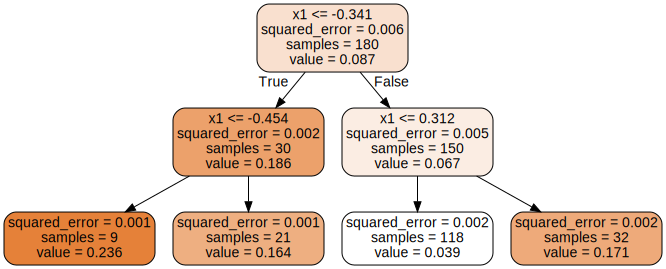

In [24]:
export_graphviz(tree_reg,
                out_file=str(IMAGE_PATH / 'reg_tree.dot'),
                feature_names=['x1'],
                rounded=True,
                filled=True)
Source.from_file(IMAGE_PATH / 'reg_tree.dot')

In [25]:
tree_reg.tree_.threshold

array([-0.34138003, -0.45416115, -2.        , -2.        ,  0.31192939,
       -2.        , -2.        ])

In [26]:
tree_reg.tree_.value

array([[[0.08715379]],

       [[0.18566247]],

       [[0.23572347]],

       [[0.16420775]],

       [[0.06745205]],

       [[0.03935803]],

       [[0.17104873]]])

In [27]:
## without any regularization, tree reg looks overfitting
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(min_samples_leaf=10, random_state=42)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

DecisionTreeRegressor(min_samples_leaf=10, random_state=42)

In [28]:
## randomly some test set
x1 = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)
x1.shape

(500, 1)

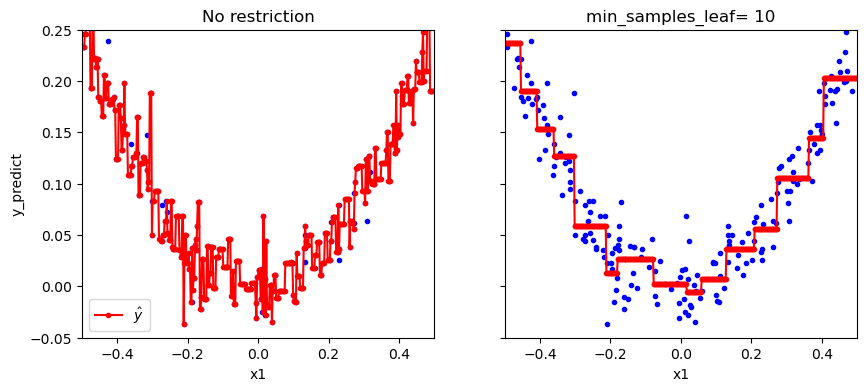

In [30]:
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, 'b.')
plt.plot(x1, y_pred1, 'r.-', label=r'$\hat{y}$')
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel('x1')
plt.ylabel('y_predict')
plt.legend()
plt.title('No restriction')

plt.sca(axes[1])
plt.plot(X, y, 'b.')
plt.plot(x1, y_pred2, 'r.-')
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel('x1')
plt.title(f'min_samples_leaf= {tree_reg2.min_samples_leaf}')
plt.show()

In [32]:
tree_reg1.tree_.threshold.shape

(399,)

In [33]:
tree_reg2.tree_.threshold.shape

(29,)

Which `min_samples_leaf` hyperparameter, the result is in much more reasonable model.

However, the tree regression has a few limitations:
- It is an orthogonal decision boundaries (all splits are prependicular to an axis), which make them to sensitive to the data's orientation (sometime, the tree has splitted data in unnecessary when data is changed to another dimensional position). One way to limit this problem is to scale the data then apply a Pricipal Component Analysis (PCA) tranformation.

### 3.1. Decision Tree have a high Variance
The main issue with the tree is that it has quite a high variance: small changes to the hyperparameters or to the data may produce very different models. For example, randomly select the set of features to evaluate at each node (`random_state=`), even retraining the same model on exact same data may produce very different model.

Luckily, the `Random Forest` class provides an average predictions over many trees. 

## Exercises
1. The depth of a well-balanced binary tree containing m leaf is equal to $log_2(m)$, rounded up. 
2. A node's Gini impurity generally is lower than its parent's (CART training algorithm's cost function, splits node in the way that minimize the weighted sum of its children's Gini). But, sometime it is greater than its parent (increase when compensated for by a decrease in the other child's impurity)
3. If the tree is overfitting, may be a good idea to decrease the `max_depth`.
4. Decision Trees don't care about the features are scaled or centered. So if Tree is underfitting, scaling features that is waste time.
5. Training time is double when we have double features in training set.

In [35]:
X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# use grid-search with cross-validation to find the best hyperparameter values for tree classifier.
from sklearn.model_selection import GridSearchCV

## setup searching hyperparameters
params = {'max_leaf_nodes' : list(range(2, 100)),
          'max_depth' : list(range(1, 7)),
          'min_samples_split' : [2, 3, 4]}

grid_searchcv = GridSearchCV(DecisionTreeClassifier(random_state=42),
                             params,
                             cv=3)

grid_searchcv.fit(Xtrain, ytrain)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]})

In [37]:
grid_searchcv.best_estimator_

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=17, random_state=42)

In [38]:
from sklearn.metrics import accuracy_score

y_pred = grid_searchcv.predict(Xtest)

accuracy_score(ytest, y_pred)

0.8595

In [39]:
best_model = grid_searchcv.best_estimator_
y_pred = best_model.predict(Xtest)
accuracy_score(ytest, y_pred)

0.8595

In [40]:
grid_searchcv.best_score_

0.8541253704877287

In [41]:
grid_searchcv.classes_

array([0, 1])